Multi-head Attention

Multi-head Attention is a module for attention mechanisms that runs through an attention mechanism several times in parallel. 
The independent attention outputs are then concatenated and linearly transformed into the expected dimension. 
Intuitively, multiple attention heads allow for attending to parts of the sequence differently (e.g., longer-term dependencies versus shorter-term dependencies).

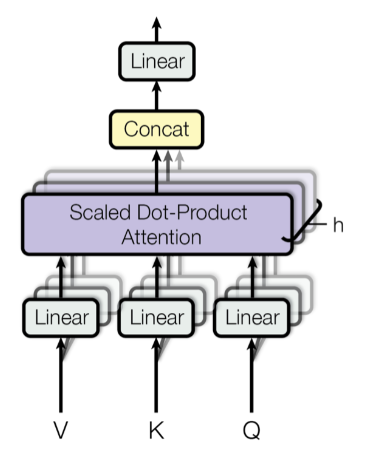


In [42]:
import torch
import torch.nn as nn
import numpy as np
import math
import torch.nn.functional as F

In [30]:
batch_size = 32
block_size = 10 # max number of words in a block
input_dim = 512
model_dim = 512
num_heads = 16

For a single head:
$$
\text{self attention} = softmax\bigg(\frac{Q.K^T}{\sqrt{d_k}}+M\bigg)
$$

$$
\text{new V} = \text{self attention}.V
$$ 

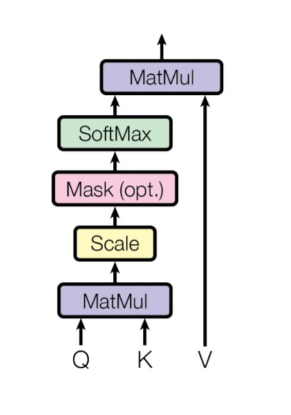

In [49]:
def scaled_dot_product_attention(q,k,v,mask=None):
    d_k = q.size(-1)
    qk = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(d_k)
    if mask is not None and mask is True:
        mask = torch.full(qk.size(),fill_value= float('-inf'))
        mask = torch.triu(mask, diagonal=1)
        qk = qk + mask 
    qk = F.softmax(qk, dim=-1)
    new_qkv = torch.matmul(qk, v)
    return new_qkv

## Multihead Self Attention

In [40]:
class Multihead_Self_Attention(nn.Module):
    def __init__(self,input_dim, model_dim, num_heads):
        super(Multihead_Self_Attention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * model_dim)
        self.concat_layer = nn.Linear(model_dim, model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,mask=None):
        qkv = self.qkv_layer(x)
        qkv = qkv.view(batch_size,block_size,num_heads,3*self.head_dim)
        qkv = qkv.permute(0,2,1,3)
        q,k,v = qkv.chunk(3,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.view(batch_size,block_size,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

## Multihead Cross Attention

In [ ]:
class Multihead_Cross_Attention(nn.Module):
    def __init__(self,input_dim, model_dim, num_heads):
        super(Multihead_Cross_Attention, self).__init__()
        self.input_dim = input_dim
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads
        self.qk_layer = nn.Linear(input_dim, 2 * model_dim)
        self.v_layer = nn.Linear(input_dim, model_dim)
        self.concat_layer = nn.Linear(model_dim, model_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self,x,y,mask=None):
        qk = self.qk_layer(x)
        v = self.v_layer(y)
        qk = qk.view(batch_size,block_size,num_heads,2*self.head_dim)
        v = v.view(batch_size,block_size,num_heads,self.head_dim)
        qk = qk.permute(0,2,1,3)
        v = v.permute(0,2,1,3)
        q,k = qk.chunk(2,dim=-1)
        new_qkv = scaled_dot_product_attention(q,k,v,mask)
        new_qkv = new_qkv.view(batch_size,block_size,self.model_dim)
        out = self.concat_layer(new_qkv)
        return out

In [54]:
x = torch.randn(batch_size,block_size,input_dim)
model = Multihead_Self_Attention(input_dim, model_dim, num_heads)
out = model.forward(x,mask = True)
out[0][0]

tensor([ 7.2639e-02, -8.3424e-02, -7.1763e-02,  2.5942e-01, -4.2767e-01,
        -7.6169e-02, -1.6445e-01,  5.6090e-02, -1.3923e-01, -4.8779e-01,
         4.4352e-01, -2.9958e-01,  4.8226e-02, -1.2359e-01, -3.1625e-01,
         1.2558e-01, -5.1916e-02, -4.3221e-02, -1.0082e-01,  4.7293e-01,
        -2.5871e-01, -5.8472e-02, -6.7958e-02,  6.8816e-02,  4.9707e-02,
        -1.1307e-01,  2.2775e-02, -4.5190e-02,  8.6831e-03,  1.1089e-01,
         1.7270e-01, -1.0120e-01,  1.4387e-01, -3.3114e-01,  2.0900e-01,
        -5.0773e-01,  2.6551e-01,  1.3502e-01,  1.4001e-02,  5.4234e-02,
        -7.0386e-02,  2.9695e-01,  3.4704e-02, -1.4597e-01,  2.2356e-03,
         5.6293e-03, -5.3637e-01,  5.0163e-02, -1.3994e-01, -1.3682e-01,
        -4.1213e-02,  2.2518e-01,  9.3361e-02,  4.6215e-02,  1.5344e-01,
         3.0574e-01, -9.1538e-02,  5.5696e-02, -2.1686e-01,  1.3409e-01,
         1.1552e-01,  2.3729e-02, -3.2750e-01, -3.3155e-01,  6.4739e-01,
        -4.0233e-02,  1.0975e-01, -1.0354e-01,  4.5